<a href="https://colab.research.google.com/github/UserSaiVarma/Computer_Vision/blob/main/8_Image_Stitching_using_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=3 color='darkblue'>Image Stitching using SIFT

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

!pip3 install -U opencv-contrib-python

<font size=2.5>Loading Images

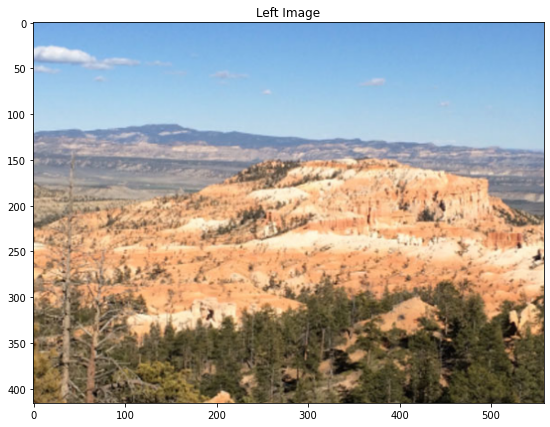

In [2]:
left_image = cv2.imread("image1.png")

plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.title("Left Image")
plt.show()

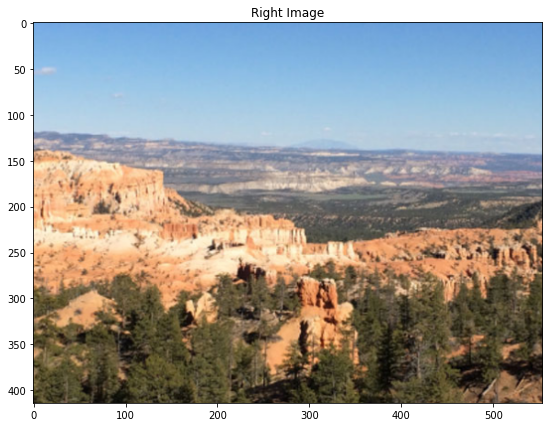

In [3]:
right_image = cv2.imread("image2.png")

plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.title("Right Image")
plt.show()

In [4]:
print("left:",left_image.shape)
print("right:", right_image.shape)

left: (416, 558, 3)
right: (414, 554, 3)


Resizing

In [5]:
#Resizing the images
height = int((left_image.shape[0]+right_image.shape[0])/2)
width = int((left_image.shape[1]+right_image.shape[1])/2)

left_image = cv2.resize(left_image, (width, height), interpolation=cv2.INTER_AREA)
right_image = cv2.resize(right_image, (width, height), interpolation=cv2.INTER_AREA)

In [6]:
print("left:",left_image.shape)
print("right:", right_image.shape)

left: (415, 556, 3)
right: (415, 556, 3)


Coverting the images to Gray Scale

In [7]:
gray_left_img = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
gray_right_img = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

In [8]:
print("left:",gray_left_img.shape)
print("right:", gray_right_img.shape)

left: (415, 556)
right: (415, 556)


Finding the features and Key points

In [9]:
def key_point_features(gray_image, original_image):
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kpts, features) = descriptor.detectAndCompute(gray_image, None)

    keypts = []
    for point in kpts:
        pt = np.float32(point.pt)
        keypts.append(pt)
    
    duplicate_image = original_image.copy()
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.drawKeypoints(gray_image,kpts,duplicate_image))
    plt.title("Key points")
    plt.show()

    return keypts, features

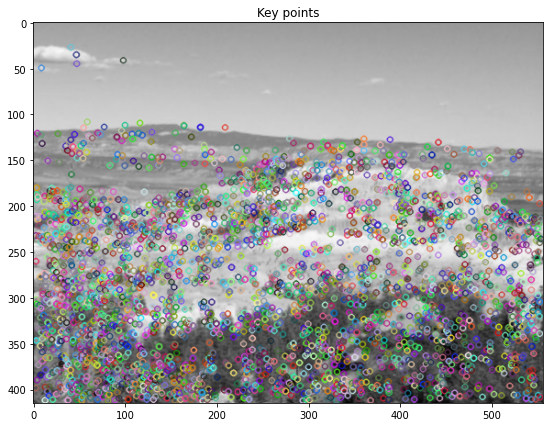

In [10]:
keypts_left, features_left = key_point_features(gray_left_img, left_image)

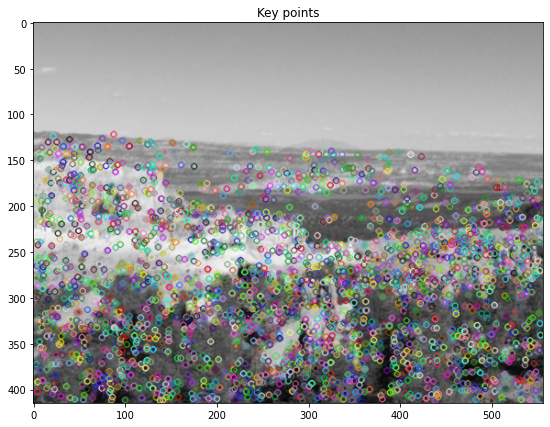

In [11]:
keypts_right, features_right = key_point_features(gray_right_img, right_image)

Matching the key points and features from two images

In [12]:
def match_pts(kpts_left, kpts_right, ftrs_left, ftrs_right, img_left, img_right, ratio=0.75, threshold=4.0):
    match_method = cv2.DescriptorMatcher_create("BruteForce")

    near_neigh = 2
    rawmatches = match_method.knnMatch(ftrs_left,ftrs_right, near_neigh)
    matches = []

    for match in rawmatches:
        if len(match)==2 and match[0].distance<match[1].distance*ratio:
            matches.append((match[0].trainIdx, match[0].queryIdx))

    if len(matches)>4:
        pts_left = []
        pts_right = []
        
        for _,idx in matches:
            pts = np.float32(kpts_left[idx])
            pts = kpts_left[idx]
            pts_left.append(pts)

        for idx,_ in matches:
            pts = np.float32(kpts_right[idx])
            pts = kpts_right[idx]
            pts_right.append(pts)

        pts_left = np.array(pts_left, dtype=np.float32)
        pts_right = np.array(pts_right, dtype=np.float32)
        Homography_matrix, status = cv2.findHomography(pts_left, pts_right, cv2.RANSAC, threshold)

        return (matches, Homography_matrix, status)
    return None

In [13]:
matches, Homography_matrix, status = match_pts(keypts_left, keypts_right, features_left, features_right, gray_left_img, gray_right_img)

Drawing Keypoint pairs

In [14]:
def visualise_matches(image1,image2,kpts1,kpts2,matches,status):
    (h1,w1)=image1.shape[0],image1.shape[1];    
    (h2,w2)=image2.shape[0],image2.shape[1];
    stack_image=np.zeros((max(h1,h2),w1+w2,3),dtype='uint8');
    stack_image[:h1,0:w1]=image1;
    stack_image[:h2,w1:]=image2;
    
    for ((trainIdx,queryIdx),stat) in zip(matches,status):
        if stat==1:
            pt1=(int(kpts1[queryIdx][0]),int(kpts1[queryIdx][1]));
            pt2=(int(kpts2[trainIdx][0])+w1,int(kpts2[trainIdx][1]));
            cv2.line(stack_image,pt1,pt2,(0,0,255),1);
            
    return stack_image

In [24]:
matched_keypts = visualise_matches(left_image, right_image, keypts_left, keypts_right, matches, status)

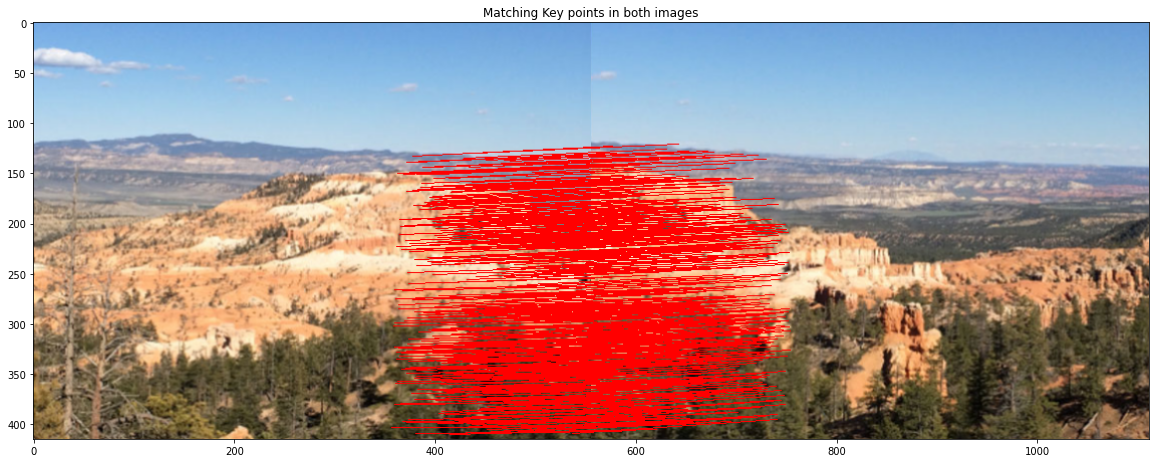

In [19]:
plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(matched_keypts, cv2.COLOR_BGR2RGB))
plt.title("Matching Key points in both images")
plt.show()

Stitching the images together

In [45]:
def warpImages(right_image, left_image, H):
  rows1, cols1 = left_image.shape[:2]
  rows2, cols2 = right_image.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(right_image, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = left_image

  return output_img

In [46]:
stitched_image = warpImages(left_image, right_image, Homography_matrix)

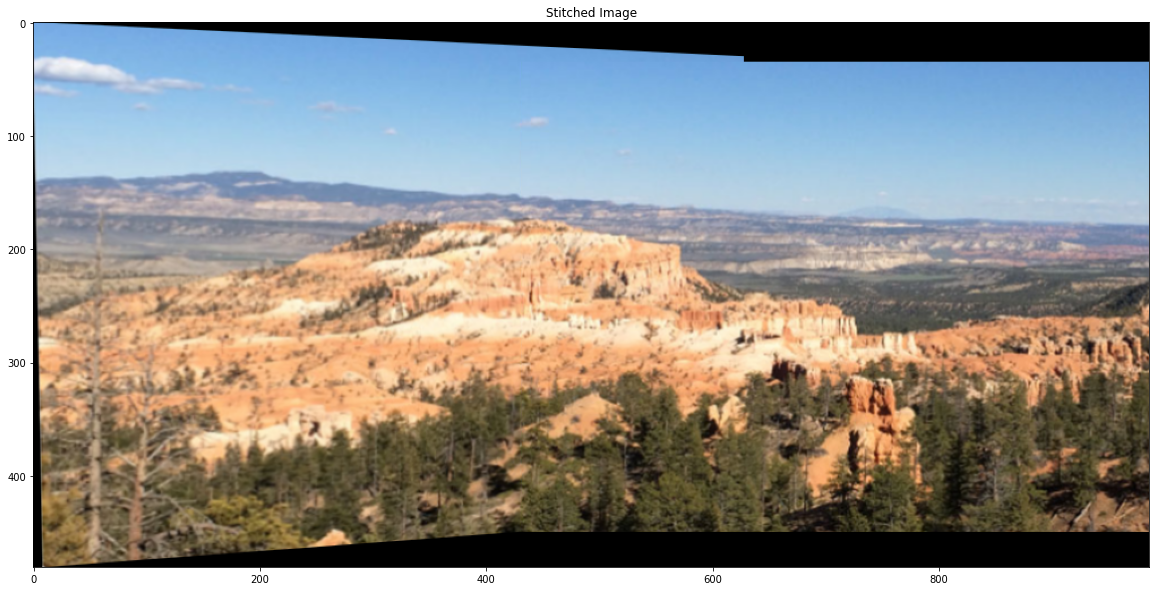

In [47]:
plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.show()